In [1]:
!date

Mon Mar  2 15:33:14 PST 2020


# NCA validation

In [7]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
import ast
from matplotlib import cm
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
#"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
#"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
#"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
#"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
#"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
#"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

In [4]:
gene =    anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")

In [5]:
gene = gene[:,gene.var.sort_values("gene_id").index]

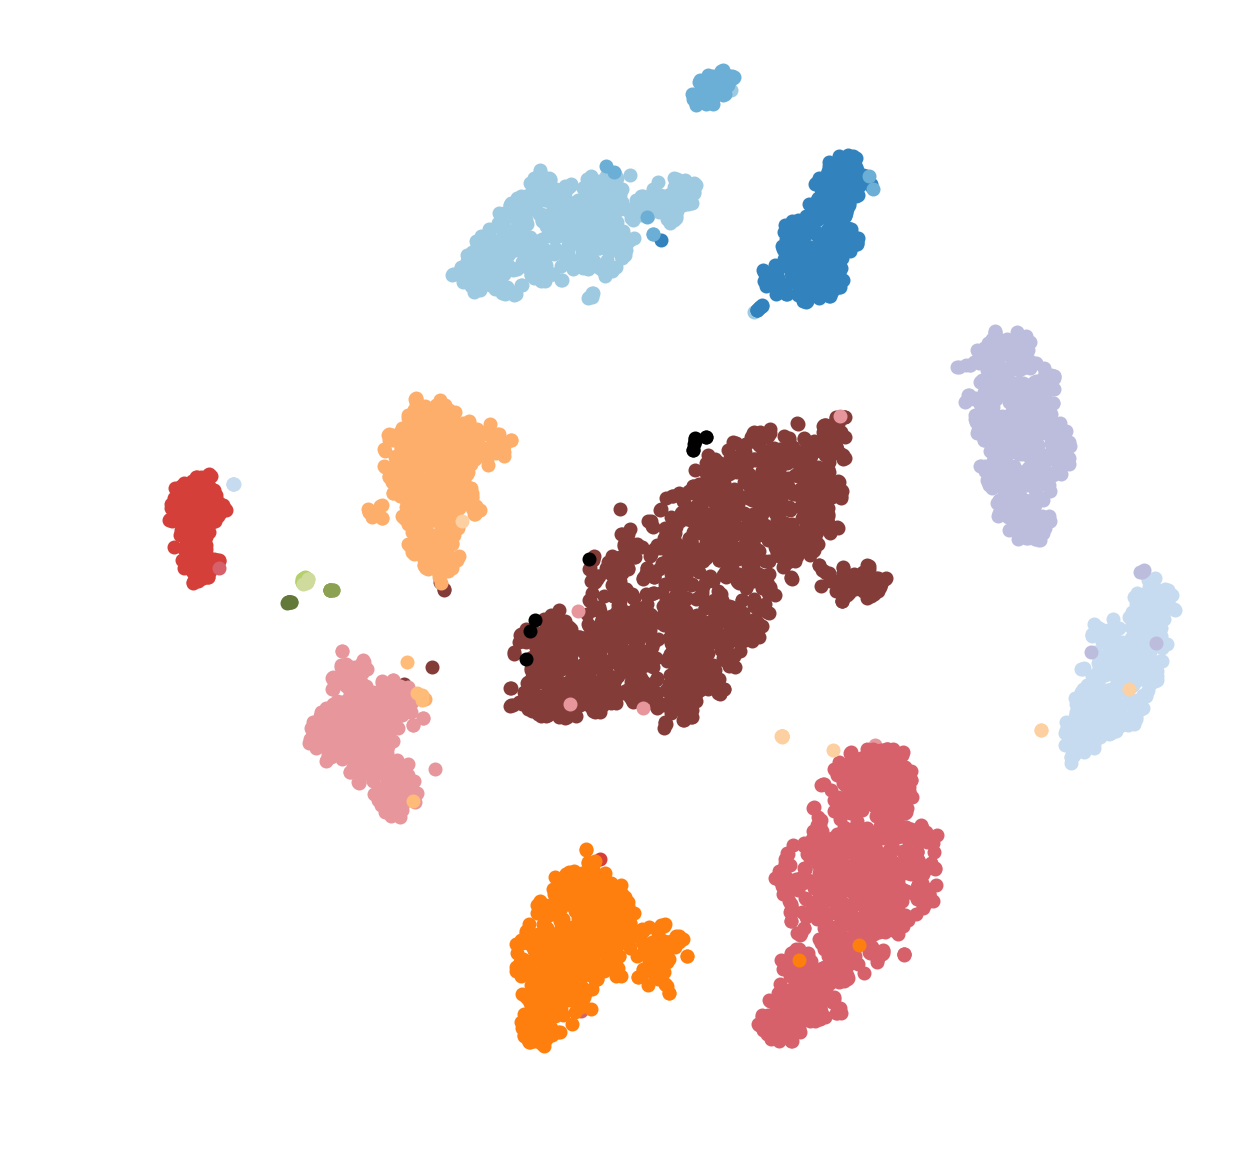

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    color = cluster_cmap[cluster]
    
    ax.scatter(x, y, color = color, label=cluster+": {:,}".format(x.shape[0]))
    # if cluster == "Endo": y = y-5; x=x+5
    # if cluster == "SMC": y = y+5; x=x+2
    # if cluster == "VLMC": x=x-20; y=y-5
    # if cluster == "L6 IT Car3": x = x+10;y=y-20
    # if cluster == "Astro": x=x-10;y=y-10
    # if cluster == "Sncg": x = x+5; y = y-5
    # ax.annotate(cluster, 
    #          (np.mean(x), np.mean(y)),
    #          horizontalalignment='center',
    #          verticalalignment='center',
    #          size=15, weight='bold',
    #          color="white",
    #            backgroundcolor=color) 
    


ax.set_axis_off()


plt.show()

In [17]:
from random import sample
from sklearn.neighbors import NeighborhoodComponentsAnalysis

In [29]:
subclass_labels = gene.obs.subclass_id.values

shuffle = np.random.permutation(subclass_labels)

In [30]:
shuffle

array([ 4, 10,  2, ...,  6,  2,  7])

In [32]:
subclass_labels

array([17,  4, 10, ..., 17, 17, 15])

In [33]:
num_NCA = 10
state=42
metric="euclidean"
num_TSNE=2

In [35]:
# NCA
X = gene.X
y = shuffle

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
Y = nca.fit_transform(X, y)

In [36]:
from sklearn.manifold import TSNE

In [37]:
XX = Y
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
YY = tsne.fit_transform(XX)

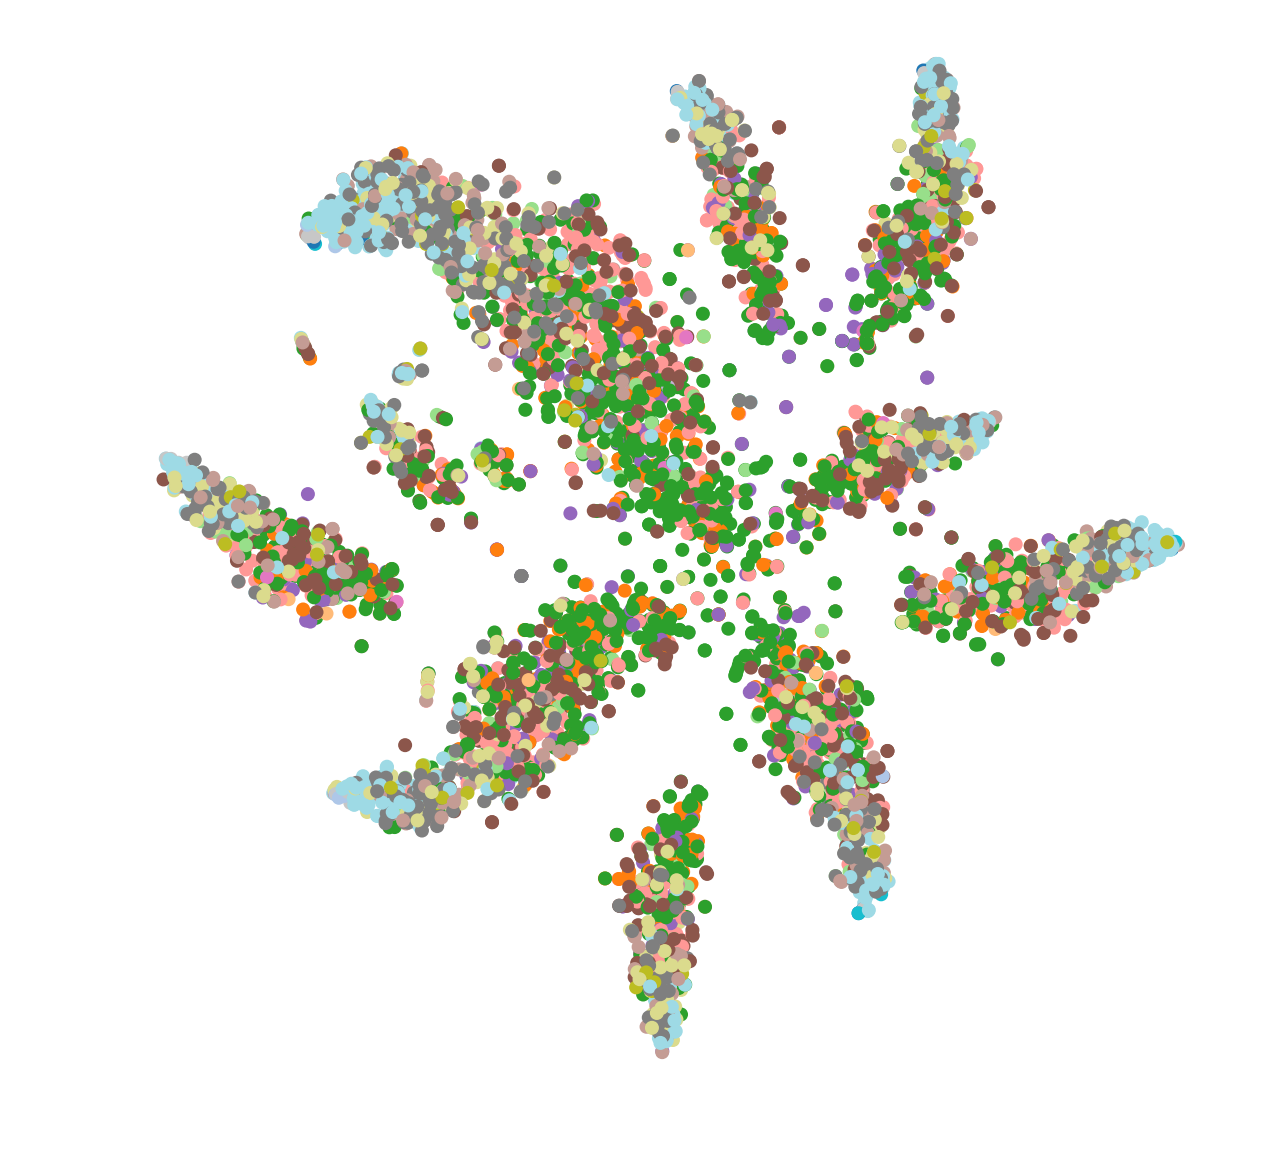

In [39]:
fig, ax = plt.subplots(figsize=(10,10))

c = subclass_labels
cmap = cm.get_cmap("tab20")


x = YY[:,0]
y = YY[:,1]


ax.scatter(x, y, c = c, cmap=cmap)

ax.set_axis_off()

plt.savefig("./figures/nca_validation.png",bbox_inches='tight', dpi=300)


plt.show()